In [1]:
import operator
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modelling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


In [2]:
# Postgres info to connect

connection_args = {
    'host': 'localhost',
    'dbname': 'nfl_db',
    'port': 5432
}

connection = pg.connect(**connection_args) # Unpacks dictionary keys and values

In [3]:
# create Jets dataframe from selected columns

query = "SELECT play_id, game_date, yards_gained, play_type, posteam, \
        ydsnet, yardline_100, quarter_seconds_remaining, qtr, down, ydstogo \
        FROM nfl_plays \
        WHERE play_type IN ('pass','run') \
        AND posteam = 'NYJ';"

df_jets = pd_sql.read_sql(query, connection)

In [4]:
df_jets.head()

,play_id,game_date,yards_gained,play_type,posteam,ydsnet,yardline_100,quarter_seconds_remaining,qtr,down,ydstogo
0,225,2009-09-13,-3.0,run,NYJ,-3,81.0,706.0,1,1.0,10
1,250,2009-09-13,0.0,pass,NYJ,-3,84.0,663.0,1,2.0,13
2,272,2009-09-13,8.0,pass,NYJ,5,84.0,656.0,1,3.0,13
3,405,2009-09-13,1.0,run,NYJ,1,74.0,515.0,1,1.0,10
4,463,2009-09-13,-1.0,run,NYJ,6,68.0,468.0,1,1.0,10


In [5]:
# create binary for if the play is a pass

df_jets['pass'] = df_jets['play_type'].apply(lambda x: 1 if x == 'pass' else 0) 
df_jets.head()

,play_id,game_date,yards_gained,play_type,posteam,ydsnet,yardline_100,quarter_seconds_remaining,qtr,down,ydstogo,pass
0,225,2009-09-13,-3.0,run,NYJ,-3,81.0,706.0,1,1.0,10,0
1,250,2009-09-13,0.0,pass,NYJ,-3,84.0,663.0,1,2.0,13,1
2,272,2009-09-13,8.0,pass,NYJ,5,84.0,656.0,1,3.0,13,1
3,405,2009-09-13,1.0,run,NYJ,1,74.0,515.0,1,1.0,10,0
4,463,2009-09-13,-1.0,run,NYJ,6,68.0,468.0,1,1.0,10,0


In [6]:
# create y for if the yards_gained were positive or not

df_jets['yards_g_l'] = df_jets['yards_gained'].apply(lambda x: 'gain' if x > 0 else 'loss')
df_jets.head()

,play_id,game_date,yards_gained,play_type,posteam,ydsnet,yardline_100,quarter_seconds_remaining,qtr,down,ydstogo,pass,yards_g_l
0,225,2009-09-13,-3.0,run,NYJ,-3,81.0,706.0,1,1.0,10,0,loss
1,250,2009-09-13,0.0,pass,NYJ,-3,84.0,663.0,1,2.0,13,1,loss
2,272,2009-09-13,8.0,pass,NYJ,5,84.0,656.0,1,3.0,13,1,gain
3,405,2009-09-13,1.0,run,NYJ,1,74.0,515.0,1,1.0,10,0,gain
4,463,2009-09-13,-1.0,run,NYJ,6,68.0,468.0,1,1.0,10,0,loss


In [7]:
df_jets.dropna(inplace=True)
df_jets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10077 entries, 0 to 10092
Data columns (total 13 columns):
play_id                      10077 non-null int64
game_date                    10077 non-null object
yards_gained                 10077 non-null float64
play_type                    10077 non-null object
posteam                      10077 non-null object
ydsnet                       10077 non-null int64
yardline_100                 10077 non-null float64
quarter_seconds_remaining    10077 non-null float64
qtr                          10077 non-null int64
down                         10077 non-null float64
ydstogo                      10077 non-null int64
pass                         10077 non-null int64
yards_g_l                    10077 non-null object
dtypes: float64(4), int64(5), object(4)
memory usage: 1.1+ MB


In [8]:
df_jets.columns

Index(['play_id', 'game_date', 'yards_gained', 'play_type', 'posteam',
       'ydsnet', 'yardline_100', 'quarter_seconds_remaining', 'qtr', 'down',
       'ydstogo', 'pass', 'yards_g_l'],
      dtype='object')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_jets.iloc[:, 5:12], df_jets.iloc[:, 12], 
                                                    test_size = 0.2, random_state=33)

In [10]:
y_test_binary = y_test.apply(lambda x: 1 if x == 'gain' else 0)
y_test_binary.head(10)

9507    0
4600    0
2584    1
4695    1
1537    0
2020    1
6338    0
3957    0
6127    1
6957    1
Name: yards_g_l, dtype: int64

In [11]:
df_jets.groupby('yards_g_l').count()
# ratio of yards gain to yards loss is 69.4% to 30.6%
# model needs to have a score better than 69.4%

,play_id,game_date,yards_gained,play_type,posteam,ydsnet,yardline_100,quarter_seconds_remaining,qtr,down,ydstogo,pass
yards_g_l,,,,,,,,,,,,
gain,6621,6621,6621,6621,6621,6621,6621,6621,6621,6621,6621,6621
loss,3456,3456,3456,3456,3456,3456,3456,3456,3456,3456,3456,3456


In [12]:
train_df = X_train.copy()
train_df['yards_g_l'] = y_train

train_df.head()

,ydsnet,yardline_100,quarter_seconds_remaining,qtr,down,ydstogo,pass,yards_g_l
6558,4,83.0,122.0,3,1.0,10,0,gain
9175,61,81.0,807.0,4,1.0,10,1,gain
7667,18,72.0,162.0,3,2.0,5,1,gain
6459,3,63.0,607.0,2,1.0,10,1,loss
5703,12,29.0,16.0,2,2.0,18,0,gain


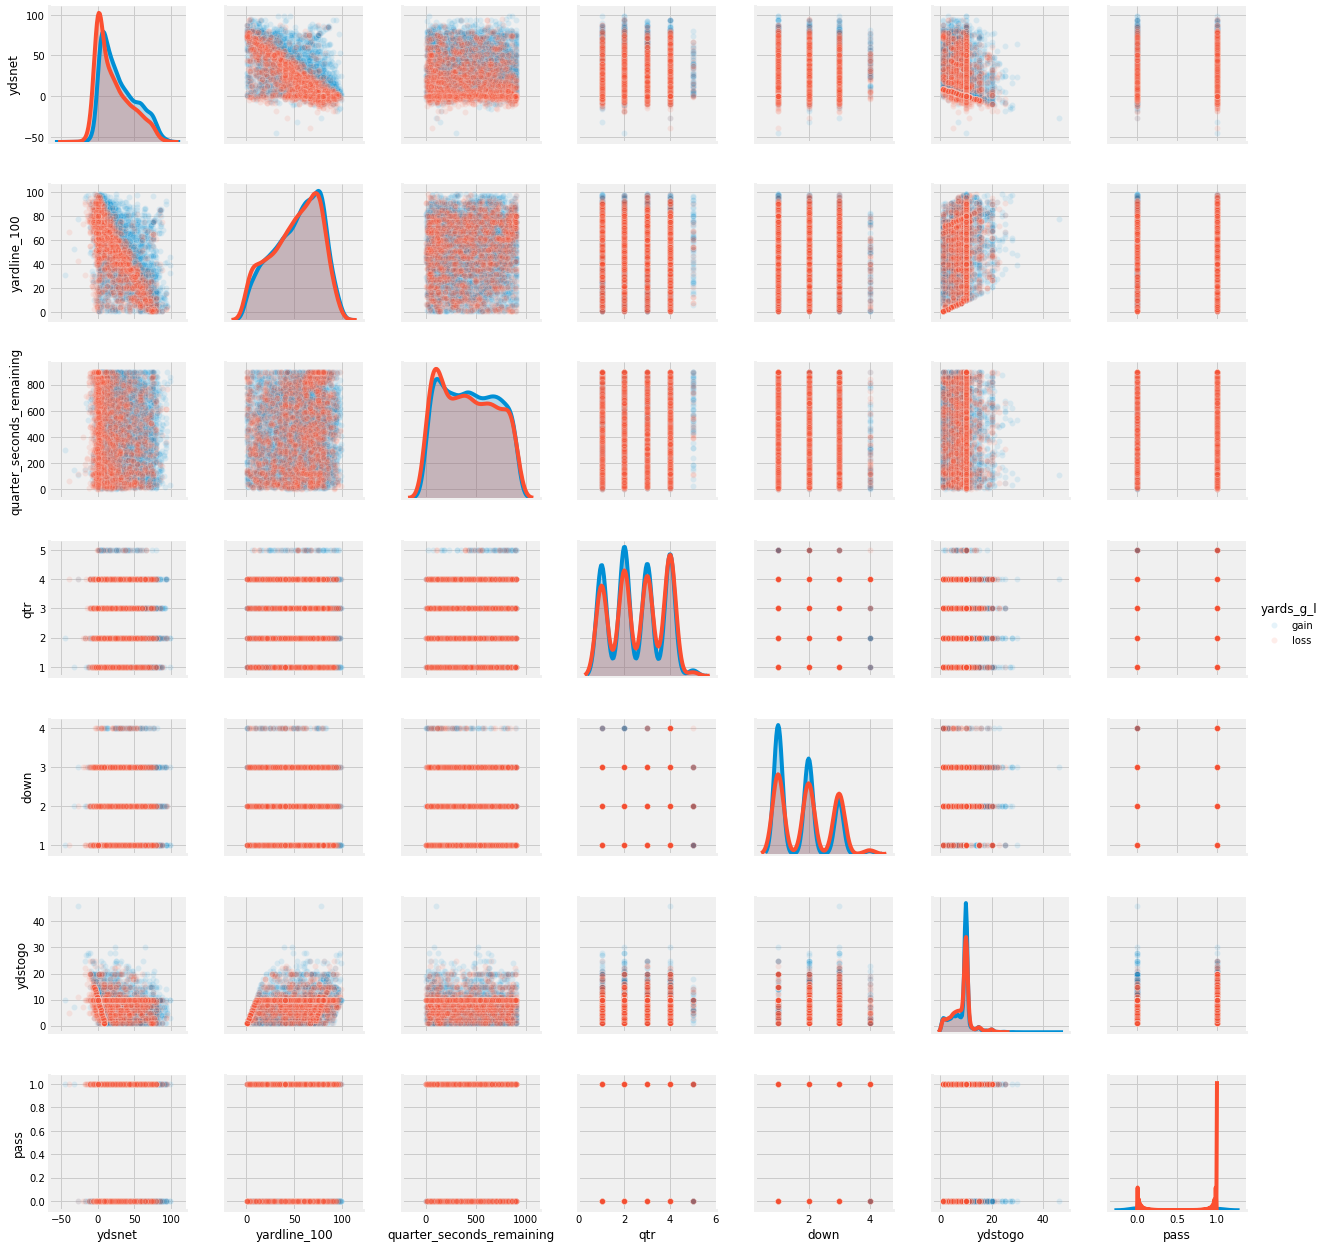

In [13]:
sns.pairplot(train_df, hue='yards_g_l', plot_kws={'alpha': 0.1});

In [14]:
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.fit_transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Logistic Regression

In [15]:
model_lr = LogisticRegression(random_state = 22)
model_lr.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=22, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
model_lr.score(X_test, y_test)

0.7514880952380952

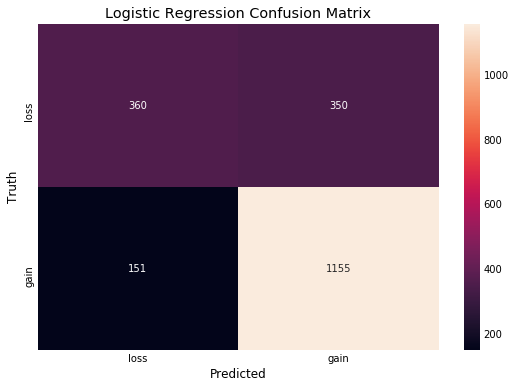

In [17]:
labels = ['loss','gain']

cm_lr = confusion_matrix(y_test, model_lr.predict(X_test), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_lr, annot=True, fmt='g').set_title('Logistic Regression Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');


In [18]:
model_lr_scaled = LogisticRegression(random_state = 12)
model_lr_scaled.fit(X_train_scaled, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=12, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
model_lr_scaled.score(X_test_scaled, y_test)

0.7475198412698413

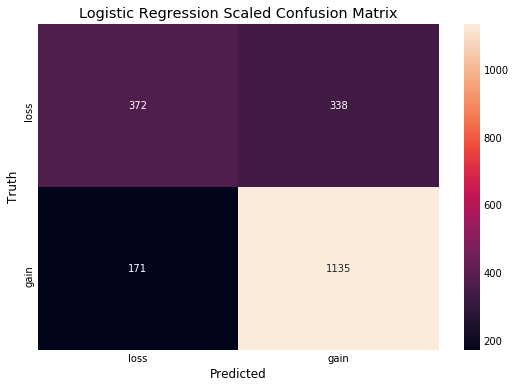

In [20]:
cm_lr_scaled = confusion_matrix(y_test, model_lr_scaled.predict(X_test_scaled), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_lr_scaled, annot=True, fmt='g').set_title('Logistic Regression Scaled Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [21]:
print(classification_report(y_test, model_lr_scaled.predict(X_test_scaled), labels))

              precision    recall  f1-score   support

        loss       0.69      0.52      0.59       710
        gain       0.77      0.87      0.82      1306

   micro avg       0.75      0.75      0.75      2016
   macro avg       0.73      0.70      0.71      2016
weighted avg       0.74      0.75      0.74      2016



ROC AUC score =  0.7824083859974549


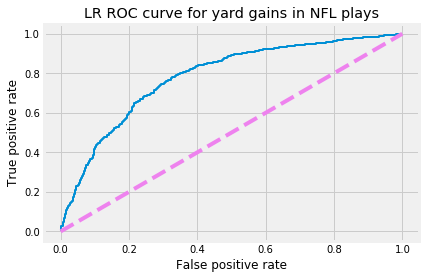

In [22]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_lr_scaled.predict_proba(X_test_scaled)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('LR ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_lr_scaled.predict_proba(X_test_scaled)[:,0]))

## KNN

In [23]:
from sklearn import neighbors
model_knn = neighbors.KNeighborsClassifier()

In [24]:
model_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [25]:
model_knn.score(X_test_scaled, y_test)

0.7192460317460317

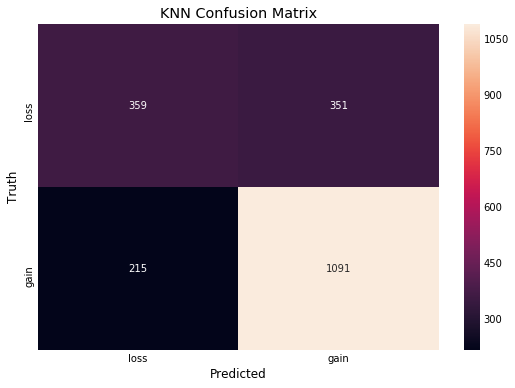

In [26]:
cm_knn = confusion_matrix(y_test, model_knn.predict(X_test_scaled), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_knn, annot=True, fmt='g').set_title('KNN Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [27]:
print(classification_report(y_test, model_knn.predict(X_test_scaled), labels))

              precision    recall  f1-score   support

        loss       0.63      0.51      0.56       710
        gain       0.76      0.84      0.79      1306

   micro avg       0.72      0.72      0.72      2016
   macro avg       0.69      0.67      0.68      2016
weighted avg       0.71      0.72      0.71      2016



ROC AUC score =  0.7396954468002502


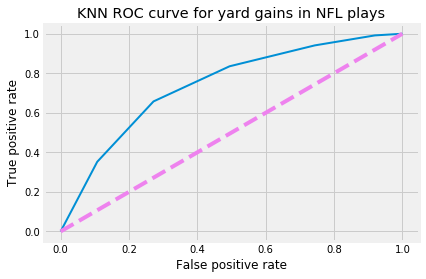

In [28]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_knn.predict_proba(X_test_scaled)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('KNN ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_knn.predict_proba(X_test_scaled)[:,0]))

## SVM

In [29]:
from sklearn.svm import SVC
model_svm = SVC(random_state = 30)

In [30]:
model_svm.fit(X_train_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=30,
  shrinking=True, tol=0.001, verbose=False)

In [31]:
model_svm.score(X_test_scaled, y_test)

0.7643849206349206

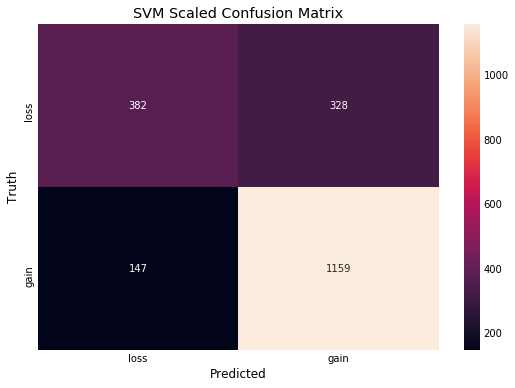

In [32]:
cm_svm = confusion_matrix(y_test, model_svm.predict(X_test_scaled), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_svm, annot=True, fmt='g').set_title('SVM Scaled Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [33]:
print(classification_report(y_test, model_svm.predict(X_test_scaled), labels))

              precision    recall  f1-score   support

        loss       0.72      0.54      0.62       710
        gain       0.78      0.89      0.83      1306

   micro avg       0.76      0.76      0.76      2016
   macro avg       0.75      0.71      0.72      2016
weighted avg       0.76      0.76      0.75      2016



## Decision Tree

In [34]:
from sklearn import tree

In [73]:
model_tree = tree.DecisionTreeClassifier(max_depth=8, random_state=44)

In [74]:
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=44,
            splitter='best')

In [75]:
model_tree.score(X_train, y_train)

0.8125542736633172

In [76]:
model_tree.score(X_test, y_test)

0.8030753968253969

In [39]:
train_score = []
test_score = []

for i in range(1,21):
    model_test = tree.DecisionTreeClassifier(max_depth=i, random_state=44)
    model_test.fit(X_train, y_train)
    train_score.append(model_test.score(X_train, y_train))
    test_score.append(model_test.score(X_test, y_test))

In [40]:
train_score


[0.721002357027664,
 0.721622627465575,
 0.7434561468800397,
 0.7521399330107927,
 0.7542488524996899,
 0.7868750775338047,
 0.7951867014018111,
 0.8125542736633172,
 0.8249596824215358,
 0.8378613075300831,
 0.8518794194268701,
 0.8673861803746433,
 0.8850018608113137,
 0.8988959186205185,
 0.9134102468676343,
 0.9268080883265104,
 0.9403299838729686,
 0.9521151221932763,
 0.9603026919737006,
 0.9698548567175288]

In [41]:
test_score

[0.716765873015873,
 0.7108134920634921,
 0.7366071428571429,
 0.7495039682539683,
 0.75,
 0.7728174603174603,
 0.7718253968253969,
 0.8030753968253969,
 0.8010912698412699,
 0.7961309523809523,
 0.7837301587301587,
 0.7787698412698413,
 0.7683531746031746,
 0.7594246031746031,
 0.7554563492063492,
 0.7504960317460317,
 0.7589285714285714,
 0.7549603174603174,
 0.7614087301587301,
 0.7485119047619048]

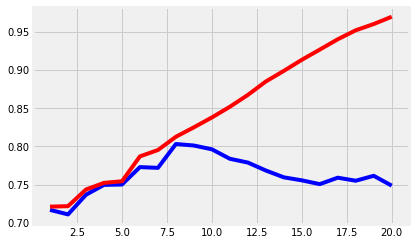

In [42]:
plt.plot(range(1,21), test_score, 'b', range(1,21), train_score, 'r')
plt.show()

# using max_depth of 8 gives best result on test set

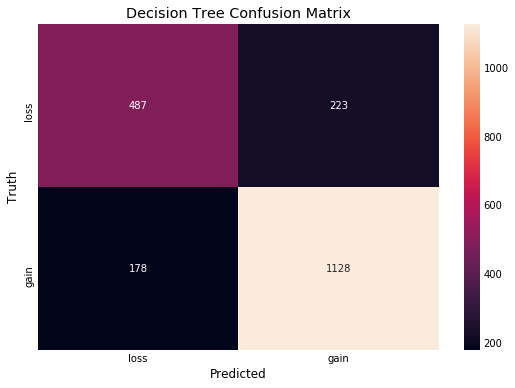

In [43]:
cm_tree = confusion_matrix(y_test, model_tree.predict(X_test), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_tree, annot=True, fmt='g').set_title('Decision Tree Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [44]:
print(classification_report(y_test, model_tree.predict(X_test), labels))

              precision    recall  f1-score   support

        loss       0.73      0.69      0.71       710
        gain       0.83      0.86      0.85      1306

   micro avg       0.80      0.80      0.80      2016
   macro avg       0.78      0.77      0.78      2016
weighted avg       0.80      0.80      0.80      2016



ROC AUC score =  0.8454840066432285


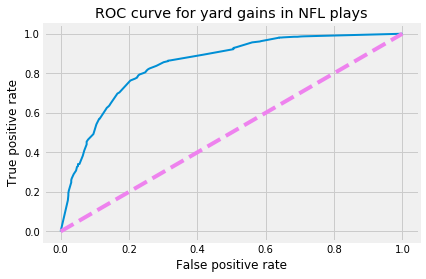

In [45]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_tree.predict_proba(X_test)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_tree.predict_proba(X_test)[:,0]))

## Naive Bayes - Gaussian

In [46]:
from sklearn import naive_bayes

In [47]:
model_NB_Gaus = naive_bayes.GaussianNB()

In [48]:
model_NB_Gaus.fit(X_train_scaled, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [49]:
model_NB_Gaus.score(X_test_scaled, y_test)

0.716765873015873

## Extra Trees

In [50]:
from sklearn import ensemble

In [51]:
model_xtrees = ensemble.ExtraTreesClassifier(n_estimators=100, random_state=15)

In [52]:
model_xtrees.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=15, verbose=0, warm_start=False)

In [53]:
model_xtrees.score(X_test, y_test)

0.7777777777777778

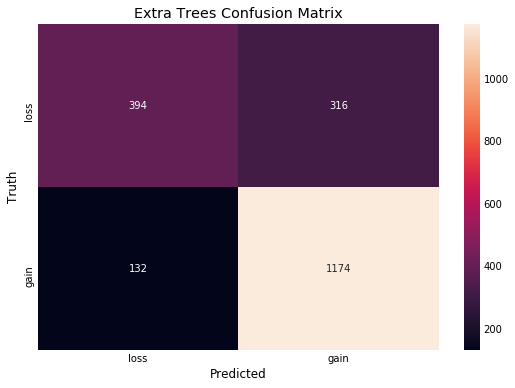

In [54]:
cm_xtrees = confusion_matrix(y_test, model_xtrees.predict(X_test), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_xtrees, annot=True, fmt='g').set_title('Extra Trees Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [55]:
print(classification_report(y_test, model_xtrees.predict(X_test), labels))

              precision    recall  f1-score   support

        loss       0.75      0.55      0.64       710
        gain       0.79      0.90      0.84      1306

   micro avg       0.78      0.78      0.78      2016
   macro avg       0.77      0.73      0.74      2016
weighted avg       0.77      0.78      0.77      2016



ROC AUC score =  0.8315294523650325


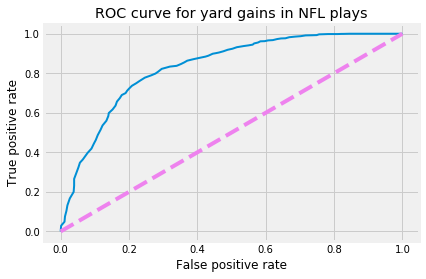

In [56]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_xtrees.predict_proba(X_test)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_xtrees.predict_proba(X_test)[:,0]))

## Random Forest

In [57]:
model_rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=15)


In [58]:
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=15, verbose=0, warm_start=False)

In [59]:
model_rf.score(X_test, y_test)

0.8095238095238095

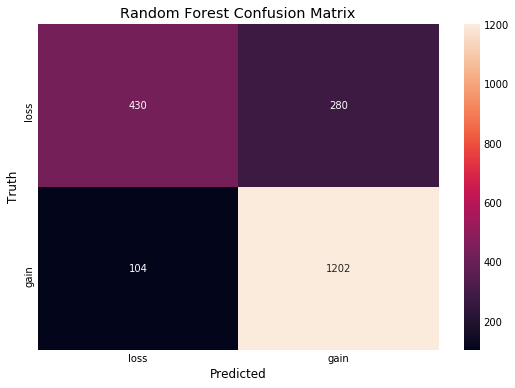

In [60]:
cm_rf = confusion_matrix(y_test, model_rf.predict(X_test), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_rf, annot=True, fmt='g').set_title('Random Forest Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [61]:
print(classification_report(y_test, model_rf.predict(X_test), labels))

              precision    recall  f1-score   support

        loss       0.81      0.61      0.69       710
        gain       0.81      0.92      0.86      1306

   micro avg       0.81      0.81      0.81      2016
   macro avg       0.81      0.76      0.78      2016
weighted avg       0.81      0.81      0.80      2016



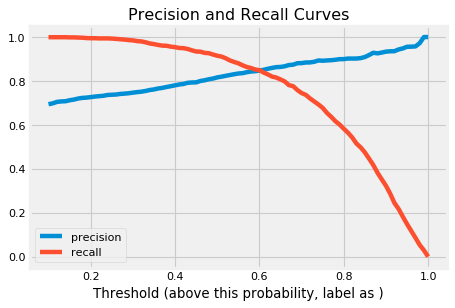

In [62]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test_binary, model_rf.predict_proba(X_test)[:,0] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as )');
plt.title('Precision and Recall Curves');


In [77]:
threshold = 0.48

predicted_proba = model_rf.predict_proba(X_test)
predicted = (predicted_proba [:,0] >= threshold).astype('int')

print(classification_report(y_test_binary, predicted))

              precision    recall  f1-score   support

           0       0.81      0.58      0.68       710
           1       0.80      0.93      0.86      1306

   micro avg       0.81      0.81      0.81      2016
   macro avg       0.81      0.75      0.77      2016
weighted avg       0.81      0.81      0.80      2016



In [78]:
threshold = np.arange(.40,.60,.01)

for i in threshold:
    predicted_proba = model_rf.predict_proba(X_test)
    predicted = (predicted_proba [:,0] >= i).astype('int')

    print(f1_score(y_test_binary, predicted))

0.8569468267581476
0.8591208030460368
0.8602150537634409
0.8618283321702721
0.8601472134595163
0.858248329229687
0.8614840989399294
0.861101243339254
0.8630527817403708
0.8622668579626972
0.8628158844765342
0.8629441624365483
0.8616283315078496
0.8590357011409643
0.8577777777777778
0.8566108007448789
0.8530734632683659
0.8516421291053228
0.8509670079635948
0.8483231707317073


ROC AUC score =  0.8603870543321183


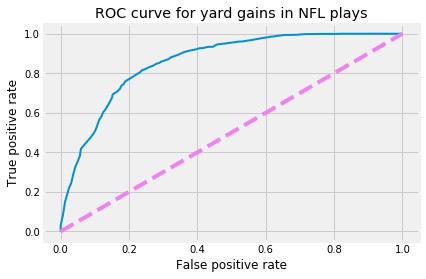

In [65]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_rf.predict_proba(X_test)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_rf.predict_proba(X_test)[:,0]))

In [66]:
## columns are ydsnet, yardline_100, quarter_seconds_remaining, qtr, down, ydstogo, pass

model_rf.predict([[78, 60.0, 350.0, 2, 1.0, 10, 0]])

array(['gain'], dtype=object)

#### Random Forest - Feature Importance - sklearn default

In [67]:
from sklearn.feature_selection import SelectFromModel

In [68]:
sel = SelectFromModel(ensemble.RandomForestClassifier(n_estimators = 100, random_state = 15))
sel.fit(X_train_scaled, y_train)
sel.get_support()

array([ True,  True,  True, False, False, False, False])

In [69]:
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['ydsnet', 'yardline_100', 'quarter_seconds_remaining'], dtype='object')


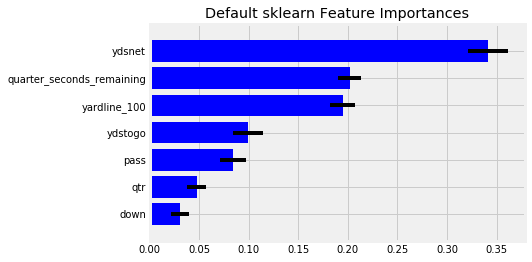

In [70]:
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Default sklearn Feature Importances")
plt.barh(range(X_train_scaled.shape[1]), importances[indices],
       color="b", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X_train_scaled.shape[1]), [X_train.columns[i] for i in indices])
plt.ylim([-1, X_train_scaled.shape[1]])
plt.show()

#### Random Forest - Feature Importance - rfpimp version

https://github.com/parrt/random-forest-importances

In [71]:
from rfpimp import *

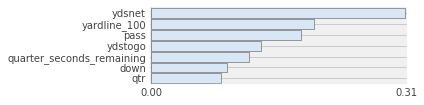

In [72]:
model_rf2 = ensemble.RandomForestClassifier(n_estimators=100, random_state=15)
model_rf2.fit(X_train, y_train)

imp = importances(model_rf2, X_train, y_train) # permutation
viz = plot_importances(imp, width=6)
viz.view()


Top 7 features in both cases are ydsnet, yardline_100, ydstogo, quarter_seconds_remaining, qtr, down, and pass